In [ ]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''
import gym
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import gym
'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('Acrobot-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")


6
3
0
----
[ 0.99962485  0.02738891  0.9989402  -0.04602639 -0.09180529 -0.09669447]
----
2
----
[ 0.99996984 -0.0077642   0.9997182  -0.02373883 -0.25169677  0.31000718]
-1.0
False
{}
----


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(64, 32) run - 1


<ipython-input-11-6afd420bda11>:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = T.distributions.Categorical(F.softmax(self.policy.forward(state)))


(64, 32) run - 2
(64, 32) run - 3
(64, 32) run - 4
(64, 32) run - 5
64 32 [ 18.2  15.8  22.8  17.4  17.6  22.6  28.6  21.6  21.8  15.2  15.   19.2
  29.4  31.4  18.2  31.   21.2  26.8  23.4  28.6  27.4  27.   30.2  32.4
  20.2  16.2  23.8  16.8  24.2  18.2  17.8  33.8  33.2  15.6  18.4  26.6
  25.2  29.8  23.8  18.2  20.   16.2  21.   35.6  26.8  34.2  30.4  22.4
  37.8  22.   18.8  23.8  21.4  22.   26.   44.   16.4  22.2  29.8  33.
  24.8  17.4  26.4  22.   28.   41.2  42.6  27.6  24.6  27.8  26.8  25.2
  29.2  34.   36.2  30.2  31.4  26.2  26.2  26.4  19.2  27.8  31.4  24.4
  29.2  19.8  44.4  38.6  34.4  30.6  31.4  29.8  50.2  20.8  32.4  25.8
  30.6  21.4  34.2  33.   34.8  35.4  29.6  23.   60.2  27.2  33.   22.4
  42.8  51.   23.2  60.   46.6  41.2  39.   35.8  48.4  47.   36.4  67.
  25.2  51.4  31.6  43.6  52.6  32.8  45.8  30.4  45.2  35.8  49.2  41.8
  49.8  44.6  40.4  43.8  23.4  25.   54.2  35.8  52.8  58.2  31.6  90.4
  37.4  63.6  66.8  47.2  57.4  37.4  56.2  64.6  51

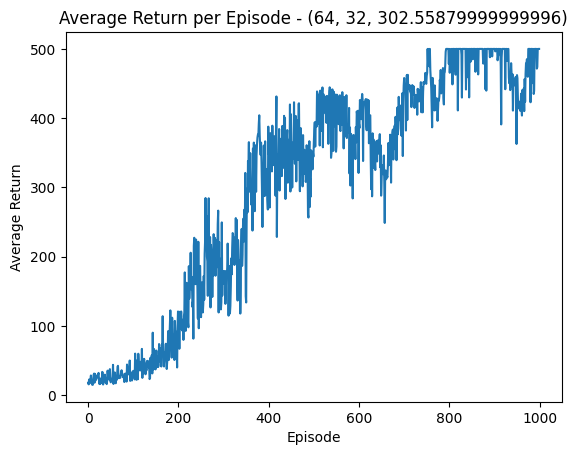

[[64, 32, 302.55879999999996]]


In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt


T.manual_seed(42)

class net1(nn.Module):
    def __init__(self, alpha, input, l1, l2,n):
        super(net1, self).__init__()
        self.input = input[0]
        self.l1 = l1
        self.l2 = l2
        self.n = n
        self.fc1 = nn.Linear(self.input, self.l1)
        self.fc2 = nn.Linear(self.l1, self.l2)
        self.fc3 = nn.Linear(self.l2, self.n)
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Agent1(object):
    def __init__(self, alpha, input,l1, l2, n, g=0.99):
        self.policy = net1(alpha, input, l1, l2,n)
        self.memory_a = []
        self.g = g
        self.memory_r = []

    def choose_action(self, state):
        state = T.tensor(state, dtype=T.float)  # Convert state to tensor
        prob = T.distributions.Categorical(F.softmax(self.policy.forward(state)))
        action = prob.sample()
        log_probs = prob.log_prob(action)
        self.memory_a.append(log_probs)
        return action.item()


    def rewards(self,reward):
        self.memory_r.append(reward)

    def learn(self):
        self.policy.optimizer.zero_grad()
        G=np.zeros_like(self.memory_r, dtype=np.float64)
        for t in range(len(self.memory_r)):
            sum_g=0
            discount=1
            for k in range(t, len(self.memory_r)):
                sum_g += self.memory_r[k] * discount
                discount *= self.g
            G[t]=sum_g
        mean=np.mean(G)
        std=np.std(G) if np.std(G) > 0 else 1
        G=(G - mean) / std
        G=T.tensor(G, dtype=T.float)
        loss=0
        for g_, logprob in zip(G, self.memory_a):
            loss += -g_* logprob
        loss.backward()
        self.policy.optimizer.step()
        self.memory_r=[]
        self.memory_a=[]



env_name = 'CartPole-v1'
num_runs = 5
num_episodes = 1000

l1=64
l2=32
values=[]

average_score = []
for run in range(num_runs):
    print(f"{l1,l2} run - {run + 1}")
    env = gym.make(env_name)
    env.reset()
    agent = Agent1(alpha=0.001, input=[env.observation_space.shape[0]], g=0.99, n=env.action_space.n, l1=l1, l2=l2)
    score_history = []

    for i in range(num_episodes):
        done = False
        score = 0
        state = env.reset()
        l=0
        while not done:
            action = agent.choose_action(state)
            state1, reward, done, info = env.step(action)
            agent.rewards(reward)
            state = state1
            score += reward
            l+=1
        score_history.append(score)
        agent.learn()
    average_score.append(score_history)

average_scores = np.mean(average_score,axis=0)
print(l1,l2,average_scores)
plt.plot(average_scores)
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.title(f'Average Return per Episode - {l1,l2,np.mean(average_scores)}')
plt.show()
values.append([l1,l2,np.mean(average_scores)])
print(values)


(32, 64) run - 1


<ipython-input-16-93ed84aff70d>:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = T.distributions.Categorical(F.softmax(self.policy.forward(state)))


(32, 64) run - 2
(32, 64) run - 3
(32, 64) run - 4
(32, 64) run - 5


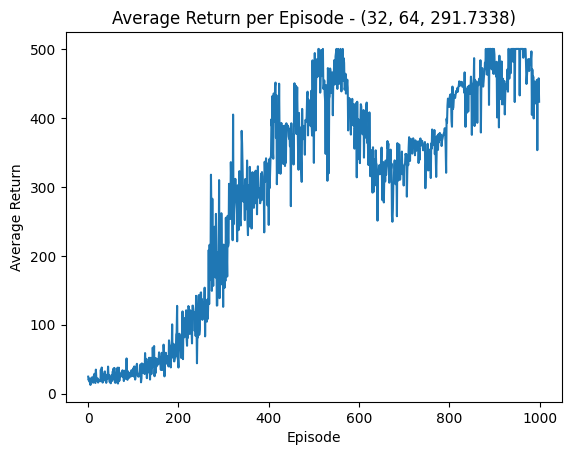

[[32, 64, 291.7338]]


In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt
T.manual_seed(42)

class net1(nn.Module):
    def __init__(self, alpha, input, l1, l2,n):
        super(net1, self).__init__()
        self.input = input[0]
        self.l1 = l1
        self.l2 = l2
        self.n = n
        self.fc1 = nn.Linear(self.input, self.l1)
        self.fc2 = nn.Linear(self.l1, self.l2)
        self.fc3 = nn.Linear(self.l2, self.n)
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Agent1(object):
    def __init__(self, alpha, input,l1, l2, n, g=0.99):
        self.policy = net1(alpha, input, l1, l2,n)
        self.memory_a = []
        self.g = g
        self.memory_r = []
        self.baseline = None

    def choose_action(self, state):
        state = T.tensor(state, dtype=T.float)
        prob = T.distributions.Categorical(F.softmax(self.policy.forward(state)))
        action = prob.sample()
        log_probs = prob.log_prob(action)
        self.memory_a.append(log_probs)
        return action.item()


    def rewards(self,reward):
        self.memory_r.append(reward)

    def learn(self):
        self.policy.optimizer.zero_grad()
        G = np.zeros_like(self.memory_r, dtype=np.float64)
        for t in range(len(self.memory_r)):
            G_sum = 0
            discount = 1
            for k in range(t, len(self.memory_r)):
                G_sum += self.memory_r[k] * discount
                discount *= self.g
            G[t] = G_sum

        self.baseline = np.mean(G)
        G = G - self.baseline
        G = T.tensor(G, dtype=T.float)

        loss = 0
        for g_, logprob in zip(G, self.memory_a):
            loss += -g_ * logprob

        loss.backward()
        self.policy.optimizer.step()

        self.memory_a = []
        self.memory_r = []



env_name = 'CartPole-v1'
num_runs = 5
num_episodes = 1000

l1=32
l2=64
values=[]

average_score_b = []
for run in range(num_runs):
    print(f"{l1,l2} run - {run + 1}")
    env = gym.make(env_name)
    env.reset()
    agent = Agent1(alpha=0.001, input=[env.observation_space.shape[0]], g=0.99, n=env.action_space.n, l1=l1, l2=l2)
    score_history = []

    for i in range(num_episodes):
        done = False
        score = 0
        state = env.reset()
        l=0
        while not done:
            action = agent.choose_action(state)
            state1, reward, done, info = env.step(action)
            agent.rewards(reward)
            state = state1
            score += reward
            l+=1
        score_history.append(score)
        agent.learn()
    average_score_b.append(score_history)
average_scores_b = np.mean(average_score_b,axis=0)

plt.plot(average_scores_b)
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.title(f'Average Return per Episode - {l1,l2,np.mean(average_scores_b)}')
plt.show()
values.append([l1,l2,np.mean(average_scores_b)])
print(values)


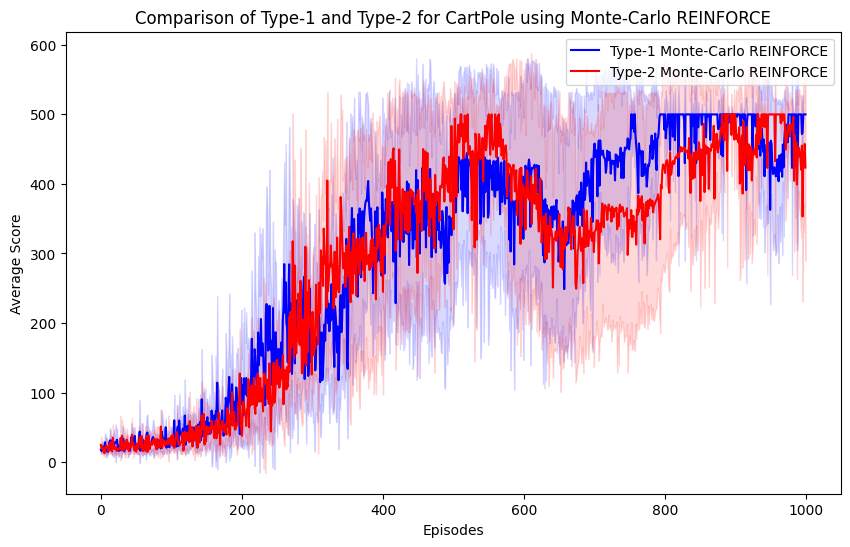

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_type1_and_type2(type1_score, type2_score, algo_name):

    type1_mean = np.mean(type1_score, axis=0)
    type1_std = np.std(type1_score, axis=0)
    type2_mean = np.mean(type2_score, axis=0)
    type2_std = np.std(type2_score, axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(type1_mean, label=f'Type-1 {algo_name}', color='blue')
    plt.fill_between(range(len(type1_mean)),
                    type1_mean - type1_std,
                    type1_mean + type1_std,
                    alpha=0.15, color='blue')
    plt.plot(type2_mean, label=f'Type-2 {algo_name}', color='red')
    plt.fill_between(range(len(type2_mean)),
                    type2_mean - type2_std,
                    type2_mean + type2_std,
                    alpha=0.15, color='red')

    plt.title(f'Comparison of Type-1 and Type-2 for CartPole using {algo_name}')
    plt.xlabel('Episodes')
    plt.ylabel('Average Score')
    plt.legend()

    # Show plot
    plt.show()

plot_type1_and_type2(average_score, average_score_b, 'Monte-Carlo REINFORCE')

